<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: MIRI LRS Time Series Observation
 
 
## Detector1Pipeline() test

<span style="color:red"> **Instruments Affected**</span>: MIRI

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Get Documentaion String for Markdown Blocks](#markdown_from_docs) <br> [Loading Data](#data_ID) <br> [Run JWST Pipeline](#pipeline_ID) <br> [Create Figure or Print Output](#residual_ID) <br> [About This Notebook](#about_ID) <br>

</div>

<a id="imports_ID"></a>
# Imports
List the library imports and why they are relevant to this notebook.


* astropy.io for opening fits files
* astropy.utils for remote data retrieval
* inspect to get the docstring of our objects.
* IPython.display for printing markdown output
* jwst.datamodels for building model for JWST Pipeline
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot to generate plot



[Top of Page](#title_ID)

In [1]:
# from astropy.io import fits
import inspect
import numpy as np
import glob
from IPython.display import Markdown
from jwst.datamodels import RampModel, ImageModel, CubeModel
from jwst.pipeline import Detector1Pipeline
import matplotlib.pyplot as plt

import astropy.io.fits as fits
from astropy.utils.data import download_file
from ci_watson.artifactory_helpers import get_bigdata
from pysiaf import Siaf

%matplotlib inline

<a id="intro_ID"></a>
# Introduction

In this notebook we're testing the Detector1Pipeline() step for MIRI Low Resolution Spectroscopy (LRS) Time Series Observations (TSOs). The step takes the Level 1 data and converraw counts to DN/s units (the "ramps to slopes" stage). This is not a TSO-specific step, so we test to ensure the pipeline runs without crashing and executes the stage as planned; there is a dedicated configuration file for stage 1 processing for TSOs, calwebb_tso1.cfg.

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html#calwebb-detector1

Pipeline code: https://github.com/spacetelescope/jwst/blob/master/jwst/pipeline/calwebb_detector1.py


### Calibration WG Requested Algorithm: 

A short description and link to the page: 


### Defining Term
Here is where you will define terms or acronymns that may not be known a general audience (ie a new employee to the institute or an external user). For example

* JWST: James Webb Space Telescope
* MIRI: Mid-Infrared Instrument
* LRS: Low Resolution Spectrometer
* TSO: Time Series Observation


[Top of Page](#title_ID)

<a id="markdown_from_docs"></a>
# Get Documentation String for Markdown Blocks

In [2]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
data_dir = TemporaryDirectory()
os.chdir(data_dir.name)

In [3]:
# Get raw python docstring
raw = inspect.getdoc(RampModel)

# To convert to markdown, you need convert line breaks from \n to <br />
markdown_text = "<br />".join(raw.split("\n"))

# Here you can format markdown as an output using the Markdown method.
Markdown("""
# RampModel
---
{}
""".format(markdown_text))


# RampModel
---
A data model for 4D ramps.<br /><br />Parameters<br />__________<br />data : numpy float32 array<br />     The science data<br /><br />pixeldq : numpy uint32 array<br />     2-D data quality array for all planes<br /><br />groupdq : numpy uint8 array<br />     4-D data quality array for each plane<br /><br />err : numpy float32 array<br />     Error array<br /><br />zeroframe : numpy float32 array<br />     Zeroframe array<br /><br />group : numpy table<br />     group parameters table<br /><br />int_times : numpy table<br />     table of times for each integration


<a id="data_ID"></a>
# Loading Data

We are using here a simulated TSO observation, generated with MIRISim. It is a single exposure of a star with 100 groups per integration and 10 integrations. LRS TSOs uses the SLITLESSPRISM subarray, so the data do not cover the full array. 

The data are stored on Box and we will retrieve from there.

[Top of Page](#title_ID)

In [4]:
mainurl ="https://data.science.stsci.edu/redirect/JWST/TSO/pipeline_testing_miri_LRS_tso/"
fname = 'pipetest_miri_lrs_tso_100G10I.fits'
fdld = download_file(mainurl+fname)
hdu = fits.open(fdld)
hdu.info()
# dm = some code to create datamodel

Filename: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/astropy-download-1820523-0ooeye3j
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     116   ()      
  1  SCI           1 ImageHDU        51   (72, 416, 100, 10)   float32   
  2  PIXELDQ       1 ImageHDU        11   (72, 416)   int32 (rescales to uint32)   
  3  REFOUT        1 ImageHDU        11   (18, 416, 100, 10)   float32   
  4  ASDF          1 BinTableHDU     11   1R x 1C   [6008B]   


### Check the data dimensions against the SIAF

In [5]:
def verify_data(hdu, aperture, tso=True):
    ''' This function will verify the format of the data extensions against the SIAF information and header keywords.
    '''
    siaf = Siaf(instrument='MIRI')
    ap = siaf[aperture]

    ap_corners = ap.corners(to_frame='det')
    ap_rows = np.int(ap_corners[1][2]-ap_corners[1][1])
    ap_cols = np.int(ap_corners[0][1]-ap_corners[0][0])
    
    h = hdu[0].header
    h_groups = h['NGROUPS']
    h_ints= h['NINTS']
    
    # these checks are generally applicable for all types of exposures
    assert np.shape(hdu['SCI'])[3] == ap_cols, "Dimensions of SCI extension don't match the SIAF"
    assert np.shape(hdu['SCI'])[2] == ap_rows, "Dimensions of SCI extension don't match the SIAF"
    assert np.shape(hdu['SCI'])[1] == h_groups, "Dimensions of SCI extensions don't match the header keyword (groups)"
    assert np.shape(hdu['SCI'])[0] == h_ints, "Dimensions of SCI extensions don't match the header keyword (integrations)"
    
    assert np.shape(hdu['PIXELDQ'])[0] == ap_rows, "Dimensions of PIXELDQ extension don't match the SIAF"
    assert np.shape(hdu['PIXELDQ'])[1] == ap_cols, "Dimensions of PIXELDQ extension don't match the SIAF" 
    
    assert np.shape(hdu['REFOUT'])[3] == np.int(ap_cols/4), "Dimensions of REFOUT extension are incompatible with the SIAF"
    assert np.shape(hdu['REFOUT'])[2] == ap_rows, "Dimensions of REFOUT extension don't match the SIAF"
    assert np.shape(hdu['REFOUT'])[1] == h_groups, "Dimensions of REFOUT extensions don't match the header keyword (groups)"
    assert np.shape(hdu['REFOUT'])[0] == h_ints, "Dimensions of REFOUT extensions don't match the header keyword (integrations)"
    
    # this check only needs to be run for TSO exposures:
    if (tso==True):
        assert h['TSOVISIT'], "TSOVISIT keyword not set to True"

In [6]:
#print(np.shape(hdu['REFOUT']))
verify_data(hdu, 'MIRIM_SLITLESSPRISM')

2021-08-27 12:06:34,657 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/ipykernel_1820523/1539562950.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ap_rows = np.int(ap_corners[1][2]-ap_corners[1][1])



2021-08-27 12:06:34,658 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/ipykernel_1820523/1539562950.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ap_cols = np.int(ap_corners[0][1]-ap_corners[0][0])



2021-08-27 12:06:34,658 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/ipykernel_1820523/1539562950.py:24: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert np.shape(hdu['REFOUT'])[3] == np.int(ap_cols/4), "Dimensions of REFOUT extension are incompatible with the SIAF"



Let's make some plots:

* look at the last frame in an integration for a counts check
* plot the ramp for a pixel on and off the spectrum.

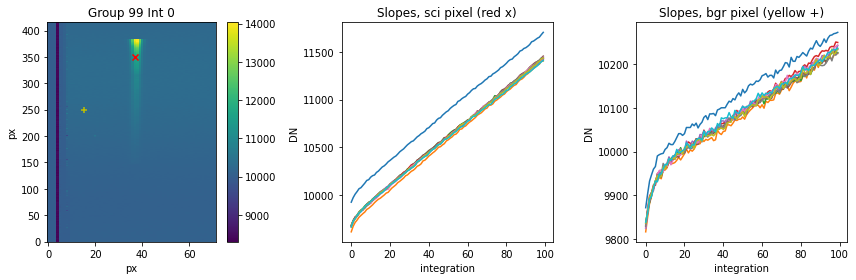

In [7]:
sci_data = hdu['SCI'].data
pri_h = hdu[0].header

ngroups = pri_h['NGROUPS']
nints = pri_h['NINTS']

# identify a science pixel
sci_px = [350, 37]

# identify a pixel in blank sky
bgr_px = [250, 15]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[12,4])

# plot 1: frame[-1] in the first integration
lastgrp = ax[0].imshow(sci_data[0,ngroups-1,:,:], origin='lower', interpolation='None', aspect='auto')
ax[0].scatter(sci_px[1], sci_px[0], marker='x', color='r', label='sci pixel')
ax[0].scatter(bgr_px[1], bgr_px[0], marker='+', color='y', label='bgr pixel')
ax[0].set_title('Group {} Int 0'.format(ngroups-1))
ax[0].set_xlabel('px')
ax[0].set_ylabel('px')

# plot 2: pixel slope, spectrum

ax[1].set_title('Slopes, sci pixel (red x)')
for i in range(nints):
    ax[1].plot(sci_data[i, :, sci_px[0], sci_px[1]])
ax[1].set_xlabel('integration')
ax[1].set_ylabel('DN')

# plot 3: pixel slope, background

ax[2].set_title('Slopes, bgr pixel (yellow +)')
for i in range(nints):
    ax[2].plot(sci_data[i, :, bgr_px[0], bgr_px[1]])
ax[2].set_xlabel('integration')
ax[2].set_ylabel('DN')

fig.colorbar(lastgrp, ax=ax[0])
fig.tight_layout()

### Check that the file can be loaded as data model

In [8]:
sci_mod = RampModel(hdu)

<a id="pipeline_ID"></a>
# Run JWST Pipeline

Here we run the Detector1Pipeline() step on the data, using all default inputs. 

[Top of Page](#title_ID)

In [9]:
#output = PipelineStep.call(dm)

configfile = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'calwebb_detector1',
                     'calwebb_detector1_miri_test', 
                     'calwebb_tso1.cfg')

step = Detector1Pipeline()
det1 = step.call(sci_mod, config_file=configfile, save_results=True)

2021-08-27 12:06:35,602 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-08-27 12:06:35,604 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-08-27 12:06:35,605 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-08-27 12:06:35,606 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-08-27 12:06:35,607 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-08-27 12:06:35,608 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-08-27 12:06:35,609 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-08-27 12:06:35,610 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-08-27 12:06:35,611 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-08-27 12:06:35,613 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-08-27 12:06:35,614 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-08-27 12:06:35,615 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-08-27 12:06:35,616 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-08-27 12:06:35,617 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-08-27 12:06:35,618 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-08-27 12:06:35,619 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-08-27 12:06:35,620 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-08-27 12:06:36,196 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0002.asdf


2021-08-27 12:06:36,213 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-08-27 12:06:36,215 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-08-27 12:06:36,216 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-08-27 12:06:36,217 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-08-27 12:06:36,218 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-08-27 12:06:36,219 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-08-27 12:06:36,220 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-08-27 12:06:36,221 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-08-27 12:06:36,222 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-08-27 12:06:36,223 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-08-27 12:06:36,223 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-08-27 12:06:36,224 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-08-27 12:06:36,225 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-08-27 12:06:36,226 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-08-27 12:06:36,227 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-08-27 12:06:36,228 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-08-27 12:06:36,229 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-08-27 12:06:36,403 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (<RampModel(10, 100, 416, 72) from astropy-download-1820523-0ooeye3j>,).


2021-08-27 12:06:36,413 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': True, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output

2021-08-27 12:06:36,422 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'astropy-download-1820523-0ooeye3j' reftypes = ['dark', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'saturation', 'superbias']


2021-08-27 12:06:36,429 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0048.fits'.


2021-08-27 12:06:36,431 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2021-08-27 12:06:36,432 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2021-08-27 12:06:36,433 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits'.


2021-08-27 12:06:36,435 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0070.fits'.


2021-08-27 12:06:36,436 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2021-08-27 12:06:36,436 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0043.fits'.


2021-08-27 12:06:36,437 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2021-08-27 12:06:36,438 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-08-27 12:06:36,439 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-08-27 12:06:36,617 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(10, 100, 416, 72) from astropy-download-1820523-0ooeye3j>,).


2021-08-27 12:06:36,619 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-08-27 12:06:36,822 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-08-27 12:06:36,823 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-08-27 12:06:36,825 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-08-27 12:06:36,996 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(10, 100, 416, 72) from astropy-download-1820523-0ooeye3j>,).


2021-08-27 12:06:36,998 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-08-27 12:06:37,017 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits


2021-08-27 12:06:37,376 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2021-08-27 12:06:37,384 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-08-27 12:06:37,501 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(10, 100, 416, 72) from astropy-download-1820523-0ooeye3j>,).


2021-08-27 12:06:37,502 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-08-27 12:06:37,519 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2021-08-27 12:06:37,761 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2021-08-27 12:06:37,996 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2021-08-27 12:06:38,007 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-08-27 12:06:38,011 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-08-27 12:06:38,139 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(10, 100, 416, 72) from astropy-download-1820523-0ooeye3j>,).


2021-08-27 12:06:38,141 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-08-27 12:06:38,141 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-08-27 12:06:38,142 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-08-27 12:06:38,234 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(10, 100, 416, 72) from astropy-download-1820523-0ooeye3j>,).


2021-08-27 12:06:38,236 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-08-27 12:06:38,236 - stpipe.Detector1Pipeline.firstframe - INFO - Step skipped.


2021-08-27 12:06:38,238 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-08-27 12:06:38,325 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(10, 100, 416, 72) from astropy-download-1820523-0ooeye3j>,).


2021-08-27 12:06:38,326 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-08-27 12:06:38,327 - stpipe.Detector1Pipeline.lastframe - INFO - Step skipped.


2021-08-27 12:06:38,328 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-08-27 12:06:38,411 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(10, 100, 416, 72) from astropy-download-1820523-0ooeye3j>,).


2021-08-27 12:06:38,412 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-08-27 12:06:38,431 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0043.fits


2021-08-27 12:06:39,360 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESET_LARGE does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-27 12:06:39,679 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-08-27 12:06:39,795 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(10, 100, 416, 72) from astropy-download-1820523-0ooeye3j>,).


2021-08-27 12:06:39,796 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-08-27 12:06:39,814 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2021-08-27 12:06:40,062 - stpipe.Detector1Pipeline.linearity - INFO - Extracting linearity subarray to match science data


2021-08-27 12:06:40,292 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-08-27 12:06:40,428 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(10, 100, 416, 72) from astropy-download-1820523-0ooeye3j>,).


2021-08-27 12:06:40,430 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-08-27 12:06:40,430 - stpipe.Detector1Pipeline.rscd - INFO - Step skipped.


2021-08-27 12:06:40,431 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-08-27 12:06:40,523 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(10, 100, 416, 72) from astropy-download-1820523-0ooeye3j>,).


2021-08-27 12:06:40,525 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-08-27 12:06:40,543 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0048.fits


2021-08-27 12:06:46,814 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=10, ngroups=100, nframes=1, groupgap=0


2021-08-27 12:06:46,815 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=1000, nframes=1, groupgap=0


2021-08-27 12:06:47,135 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-08-27 12:06:47,286 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(10, 100, 416, 72) from astropy-download-1820523-0ooeye3j>,).


2021-08-27 12:06:47,287 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-08-27 12:06:47,295 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2021-08-27 12:06:47,296 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2021-08-27 12:06:47,296 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2021-08-27 12:06:47,297 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.000000


2021-08-27 12:06:47,297 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2021-08-27 12:06:47,511 - stpipe.Detector1Pipeline.refpix - WARNING - Refpix correction skipped for MIRI subarrays


2021-08-27 12:06:47,513 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-08-27 12:06:47,616 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(10, 100, 416, 72) from astropy-download-1820523-0ooeye3j>,).


2021-08-27 12:06:47,618 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-08-27 12:06:47,625 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-08-27 12:06:47,636 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-08-27 12:06:47,661 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0070.fits


2021-08-27 12:06:47,682 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-08-27 12:06:47,891 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2021-08-27 12:06:47,980 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-08-27 12:06:48,195 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-08-27 12:06:48,334 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 4166 pixels with at least one CR and at least four groups


2021-08-27 12:06:48,335 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-08-27 12:06:48,335 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2021-08-27 12:06:48,565 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-08-27 12:06:48,708 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 4287 pixels with at least one CR and at least four groups


2021-08-27 12:06:48,709 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-08-27 12:06:48,710 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2021-08-27 12:06:48,948 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-08-27 12:06:49,061 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 4333 pixels with at least one CR and at least four groups


2021-08-27 12:06:49,062 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-08-27 12:06:49,063 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2021-08-27 12:06:49,306 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2021-08-27 12:06:49,444 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 4248 pixels with at least one CR and at least four groups


2021-08-27 12:06:49,445 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-08-27 12:06:49,446 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2021-08-27 12:06:49,686 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 5:


2021-08-27 12:06:49,818 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 4267 pixels with at least one CR and at least four groups


2021-08-27 12:06:49,819 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-08-27 12:06:49,819 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2021-08-27 12:06:50,054 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 6:


2021-08-27 12:06:50,195 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 4309 pixels with at least one CR and at least four groups


2021-08-27 12:06:50,196 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-08-27 12:06:50,196 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2021-08-27 12:06:50,402 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 7:


2021-08-27 12:06:50,514 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 4266 pixels with at least one CR and at least four groups


2021-08-27 12:06:50,515 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-08-27 12:06:50,516 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2021-08-27 12:06:50,724 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 8:


2021-08-27 12:06:50,866 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 4286 pixels with at least one CR and at least four groups


2021-08-27 12:06:50,867 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-08-27 12:06:50,868 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2021-08-27 12:06:51,076 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 9:


2021-08-27 12:06:51,190 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 4270 pixels with at least one CR and at least four groups


2021-08-27 12:06:51,191 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-08-27 12:06:51,192 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2021-08-27 12:06:51,403 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 10:


2021-08-27 12:06:51,544 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 4285 pixels with at least one CR and at least four groups


2021-08-27 12:06:51,545 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-08-27 12:06:51,545 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and two groups


2021-08-27 12:06:51,760 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 3.77932 sec


2021-08-27 12:06:51,765 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 4.139742


2021-08-27 12:06:51,768 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-08-27 12:06:52,025 - stpipe.Detector1Pipeline - INFO - Saved model in astropy-download-1820523-0ooeye3j_ramp.fits


2021-08-27 12:06:52,169 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(10, 100, 416, 72) from astropy-download-1820523-0ooeye3j_ramp.fits>,).


2021-08-27 12:06:52,171 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-08-27 12:06:52,199 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0070.fits


2021-08-27 12:06:52,212 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-08-27 12:06:52,228 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-08-27 12:06:52,229 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-08-27 12:06:52,229 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2021-08-27 12:06:52,230 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 0


2021-08-27 12:08:00,066 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 100


2021-08-27 12:08:00,067 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 10


2021-08-27 12:08:00,140 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-08-27 12:08:00,268 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(416, 72) from astropy-download-1820523-0ooeye3j_ramp.fits>,).


2021-08-27 12:08:00,270 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-08-27 12:08:00,303 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-08-27 12:08:00,303 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-08-27 12:08:00,306 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-08-27 12:08:00,390 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(10, 416, 72) from astropy-download-1820523-0ooeye3j_ramp.fits>,).


2021-08-27 12:08:00,391 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-08-27 12:08:00,421 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-08-27 12:08:00,421 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-08-27 12:08:00,424 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-08-27 12:08:00,475 - stpipe.Detector1Pipeline - INFO - Saved model in astropy-download-1820523-0ooeye3j_rateints.fits


2021-08-27 12:08:00,476 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-08-27 12:08:00,516 - stpipe.Detector1Pipeline - INFO - Saved model in astropy-download-1820523-0ooeye3j_rate.fits


2021-08-27 12:08:00,517 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


<a id="residual_ID"></a>
# Output checks

We will not look into the individual outputs of the steps as the algorithms should be similar to non-TSO observations. Items to verify:

* can both the rate and rateints file be loaded as a datamodel?
* plot the time series in DN/s of the rateints file
* are the values in the rateints file comparable with that seen in the rate file?
* is the rate seen for the sci & background pixels consistent with the ramp values seen in DN?



[Top of Page](#title_ID)

### Load in the output files

These were stored in the working directory with extensions \_rate.fits and \_rateints.fits. The rate file is compatible with the ImageModel, rateints file with CubeModel.

In [10]:
rfile = glob.glob('*_rate.fits')
rifile = glob.glob('*_rateints.fits')
print(rfile)
print(rifile)

rmod = ImageModel(rfile[0])
rimod = CubeModel(rifile[0])

['astropy-download-1820523-0ooeye3j_rate.fits']
['astropy-download-1820523-0ooeye3j_rateints.fits']


### Simple format checks

In [11]:
print('Shape of the rate file: {}'.format(np.shape(rmod.data)))
print('Shape of the rateints file: {}'.format(np.shape(rimod.data)))

assert np.shape(rimod)[1] == np.shape(rmod)[0], "Shapes of rate and rateints file don't match"
assert np.shape(rimod)[2] == np.shape(rmod)[1], "Shapes of rate and rateints file don't match"
assert np.shape(rimod)[0] == nints, "Shape of rateints model doesn't match the exposure specification"
assert np.shape(rimod)[1] == np.shape(sci_mod)[2], "Shape of output doesn't match input model"
assert np.shape(rimod)[2] == np.shape(sci_mod)[3], "Shape of output doesn't match input model"

Shape of the rate file: (416, 72)
Shape of the rateints file: (10, 416, 72)


### Produce plots

Max DN/s in the rate.fits slope image: 241.6599884033203 DN/s
Max DN/s of the median of the rateints.fits slope images: 241.66192626953125 DN/s


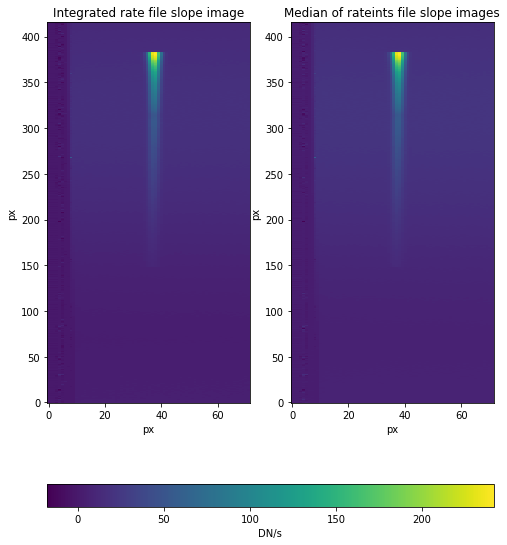

In [12]:
# this plot will compare the slope image from the _rate file with the median of the slope images in the rateints file
# check criterion: they should look similar and the maximim values seen in both these images should be similar
# NOTE: what is the numerical criterion to check for? not sure.

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[8,10])

rplt = ax[0].imshow(rmod.data, origin='lower', aspect='auto', interpolation='None')
ax[0].set_title('Integrated rate file slope image')
ax[0].set_xlabel('px')
ax[0].set_ylabel('px')

riplt = ax[1].imshow(np.median(rimod.data, axis=0), origin='lower', aspect='auto', interpolation='None')
ax[1].set_title('Median of rateints file slope images')
ax[1].set_xlabel('px')
ax[1].set_ylabel('px')

cbar = fig.colorbar(rplt, ax=ax, orientation='horizontal')
cbar.set_label('DN/s')
#fig.tight_layout()

print('Max DN/s in the rate.fits slope image: {} DN/s'.format(np.max(rmod.data)))
print('Max DN/s of the median of the rateints.fits slope images: {} DN/s'.format(np.max(np.median(rimod.data, axis=0))))

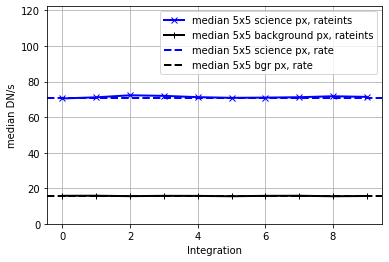

In [13]:
# Second plot looks at the time series across the NINTS integrations for a 5-pixel box around the 2 reference pixels we defined above.
# Not sure what the numerical check shoudl be here but:
# * the full and dashed lines should be very similar
# * the blue line should be higher than the black line

scibox = np.zeros(nints)
bgrbox = np.zeros(nints)

ratescibox = np.median(rmod.data[sci_px[0]-2:sci_px[0]+3, sci_px[1]-2:sci_px[1]+3])
ratebgrbox = np.median(rmod.data[bgr_px[0]-2:bgr_px[0]+3, bgr_px[1]-2:bgr_px[1]+3])

for i in range(nints):
    scibox[i] = np.median(rimod.data[i,sci_px[0]-2:sci_px[0]+3, sci_px[1]-2:sci_px[1]+3])
    bgrbox[i] = np.median(rimod.data[i,bgr_px[0]-2:bgr_px[0]+3, bgr_px[1]-2:bgr_px[1]+3])


fig, ax = plt.subplots()
ax.plot(scibox, 'bx-', lw=2, label='median 5x5 science px, rateints')
ax.plot(bgrbox, 'k+-', lw=2, label='median 5x5 background px, rateints')
ax.axhline(y=ratescibox, ls='--', lw=2, color='b', label='median 5x5 science px, rate')
ax.axhline(y=ratebgrbox, ls='--', lw=2, color='k', label='median 5x5 bgr px, rate')
ax.grid()
ax.set_xlabel('Integration')
ax.set_ylabel('median DN/s')
ax.set_ylim([0, np.max(scibox)+50])
ax.legend(loc='best')

### Integration times table (TO DO)

The output rateints file shoudl contain an extension with a table listing the start and end times for each integration. Chekc that this is present, and that the times are consistent with the exposure start time and group time.

NOTE: this can currently not be tested as the simulated data do not contain the INT_TIMES data.

### DQ Extenstion (TO DO)

Should include some checks on the Data Quality flags.

## END

<a id="about_ID"></a>
## About this Notebook
**Author:** Sarah Kendrew, ESA Instrument Scientist, MIRI branch
<br>**Updated On:** 24 July 2020

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 